Data:  
https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/neuron_10k_v3   
https://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_10k_v3/neuron_10k_v3_raw_feature_bc_matrix.tar.gz

# Is the "arm" in the saturation plot in other datasets also blood cells? 
Since this is a dataset from a mammal (mouse), the arm might contain reticulocytes. Reticulocytes are the immature non-nucleated RBCs that contain residual RNA and mitochondria.

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [2]:
import sys
import anndata
import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

# Packages to transpose CellRanger matrix
from scipy.io import mmread, mmwrite 
from kb_python.utils import import_matrix_as_anndata

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [3]:
# set random seed
np.random.seed(926)

___

# Load data

In [4]:
## Run in the terminal:
# ! tar -xvzf ../../finchseq_data/mouse/neuron_10k_v3_raw_feature_bc_matrix.tar.gz

In [5]:
# mmwrite("../../finchseq_data/mouse/matrix.T", mmread("../../finchseq_data/mouse/raw_feature_bc_matrix/matrix.mtx.gz").T.tocsr())

In [6]:
# # In terminal:
# ! gunzip features.tsv.gz
# ! cut -f 1 -d$'\t' features.tsv > new_festures.tsv

In [7]:
# matrix_path = "../../finchseq_data/mouse/matrix.T.mtx"
# barcodes_path = "../../finchseq_data/mouse/raw_feature_bc_matrix/barcodes.tsv.gz"
# genes_path = "../../finchseq_data/mouse/raw_feature_bc_matrix/new_festures.tsv"

# adata = import_matrix_as_anndata(matrix_path, barcodes_path, genes_path, t2g_path=None, name='gene')
# adata

In [8]:
# adata.write("../../finchseq_data/mouse/adata_raw.h5ad")

In [9]:
adata = anndata.read('../../finchseq_data/mouse/adata_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 6794880 × 31053

___

# Knee plot

In [10]:
# Expected number of cells:
expected_num_cells = 12000 

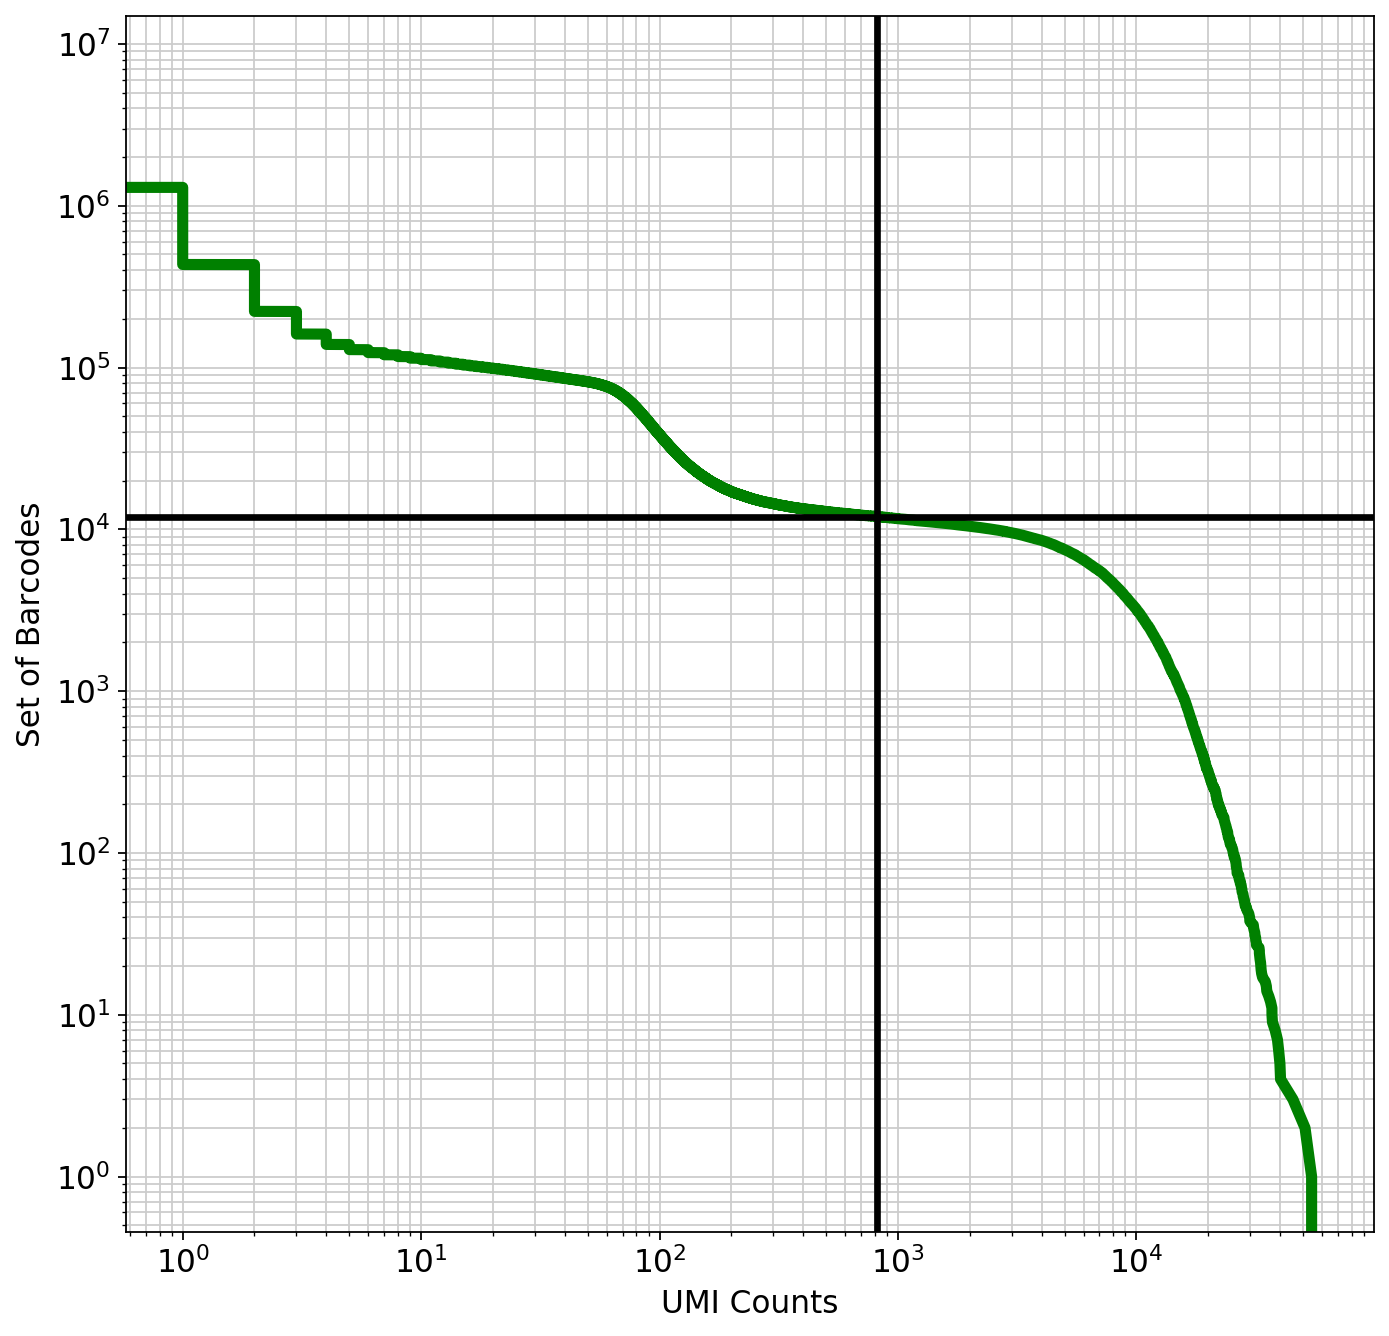

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")
# ax.set_title("{}".format(adata.obs.batch.values[0]))

ax.grid(True, which="both")

fig.show()

___

# Basic filtering based on knee plot

In [12]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells]
print("The minimum number of UMI counts based on the knee plot is: "+str(min_umi))

# Removes cells with less than min_umi umi counts
adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata.obs['n_counts_processed'] = adata.X.sum(axis=1)

print(adata)

The minimum number of UMI counts based on the knee plot is: 820.0
AnnData object with n_obs × n_vars = 11999 × 31053
    obs: 'n_counts_processed'


___

# Standard library saturation graph

In [13]:
# Function to add linear graph NOTE: call yex after defining x and y scale !!!
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set(**{
        "aspect": "equal",
        "xlim": lims,
        "ylim": lims
    })
    return ax

In [14]:
x_cutoff = 2500
y_cutoff = 950

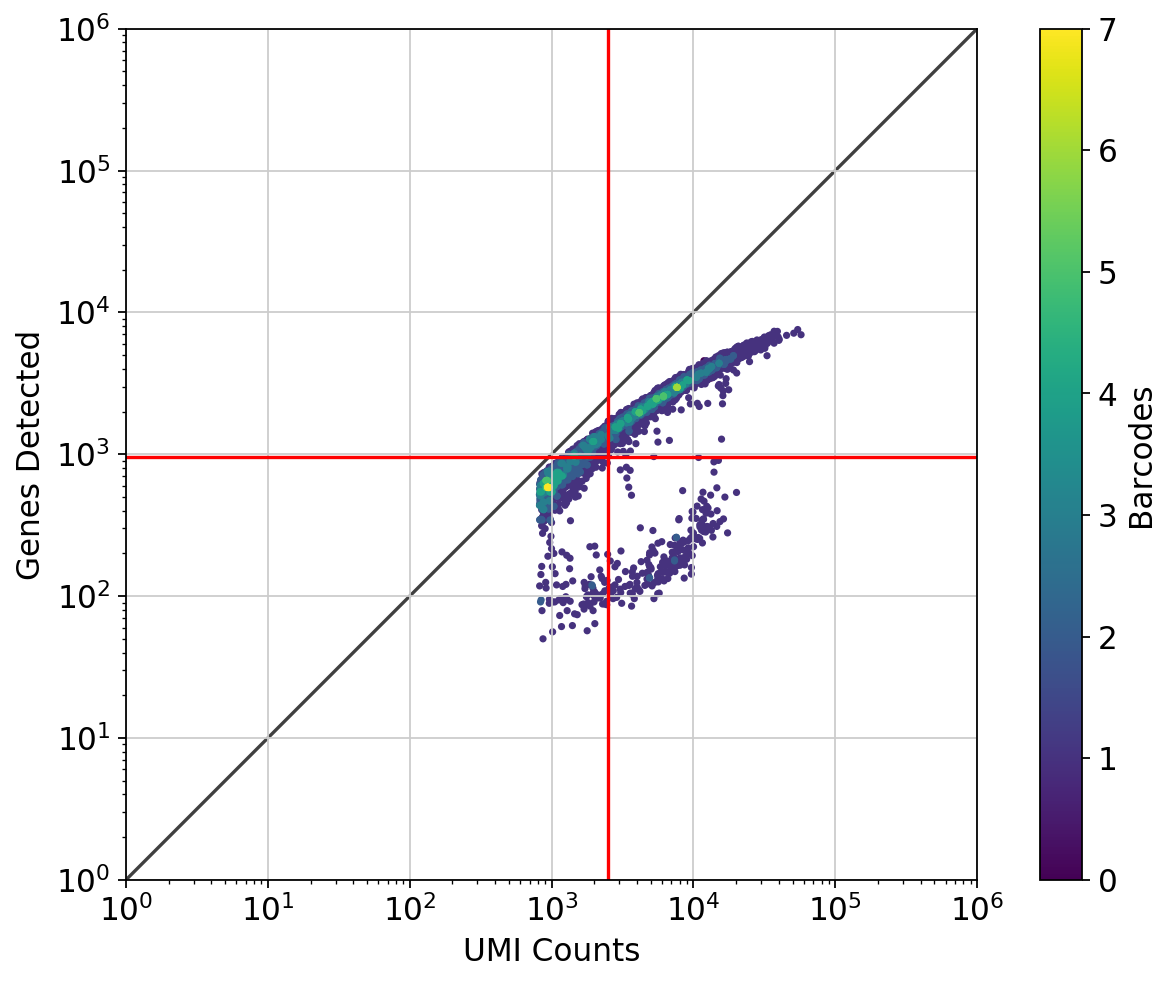

In [15]:
fig, ax = plt.subplots(figsize=(10,7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]


scatter = ax.scatter(x2, y2, c=z2, s=5, cmap='viridis')  
fig.colorbar(scatter, ax=ax, label="Barcodes")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xlim(1, 10**6)
ax.set_ylim(1, 10**6)
# ax.set_title("{}".format(adata.obs.batch.values[0]))

ax.axhline(y=y_cutoff, color="r", linestyle="-")
ax.axvline(x=x_cutoff, color="r", linestyle="-")

yex(ax)

fig.show()

___

# Find DE genes in arm

Create masks to get the subsets of the AnnData object corresponding to the side arm and the main data:

In [16]:
arm_mask = np.logical_and(adata.X.sum(axis=1)>x_cutoff, np.sum(adata.X>0, axis=1)<y_cutoff)
print("Number of cells in arm: ", np.count_nonzero(arm_mask))

Number of cells in arm:  188


In [17]:
adata.obs["arm"]="main"

for idx, value in enumerate(arm_mask):
    if value == True:
        adata.obs["arm"][idx] = "arm"

# # This should be the right way to do this, but it does not work for some reason:
# adata_4E.obs.loc[arm_mask, "arm"] = True

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
print("Number of cells in arm: ", len(adata.obs[adata.obs["arm"]=="arm"]))

Number of cells in arm:  188


Find differentially expressed genes:

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  foldchanges[global_indices]


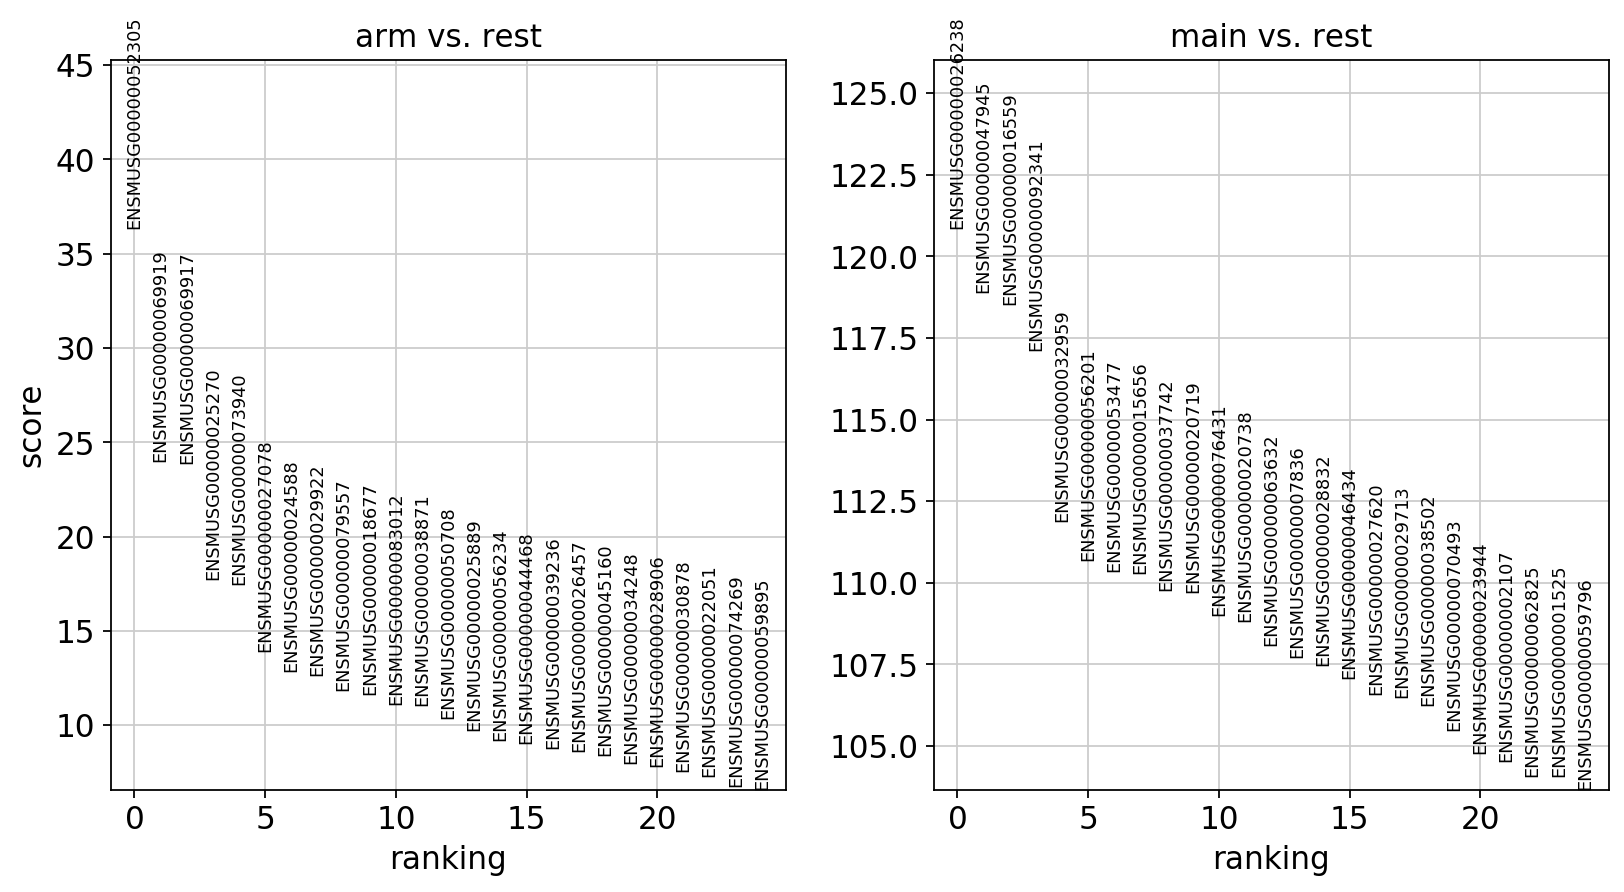

In [19]:
sc.tl.rank_genes_groups(adata, groupby='arm', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save=False)

In [20]:
arm_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [21]:
arm_markers["arm_gene_function"] = ["hemoglobin, beta adult s chain", "hemoglobin alpha, adult chain 1", "hemoglobin alpha, adult chain 2", "aminolevulinic acid synthase 2", "hemoglobin, beta adult t chain"]
arm_markers

,arm,main,arm_gene_function
0,ENSMUSG00000052305,ENSMUSG00000026238,"hemoglobin, beta adult s chain"
1,ENSMUSG00000069919,ENSMUSG00000047945,"hemoglobin alpha, adult chain 1"
2,ENSMUSG00000069917,ENSMUSG00000016559,"hemoglobin alpha, adult chain 2"
3,ENSMUSG00000025270,ENSMUSG00000092341,aminolevulinic acid synthase 2
4,ENSMUSG00000073940,ENSMUSG00000032959,"hemoglobin, beta adult t chain"


___

# Saturation graphs with previously known marker gene heatmaps

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4522225/  
Red blood cells: CD235a - ENSMUSG00000051839  
Hemoglobin: hemoglobin, beta adult s chain ENSMUSG00000052305, hemoglobin alpha, adult chain 1 ENSMUSG00000069919, hemoglobin alpha, adult chain 2 ENSMUSG00000069917
Panleukocyte marker: CD45 (Ptprc) - ENSMUSG00000026395  
Maturation marker/reticulocytes: CD71 (Tfrc) - ENSMUSG00000022797  

In [27]:
RBC_genes = [
    "ENSMUSG00000051839",
    "ENSMUSG00000052305",
    "ENSMUSG00000069919",
    "ENSMUSG00000069917",
]

titles_RBC = [
    "RBC marker CD235a",
    "Hemoglobin beta s chain",
    "Hemoglobin chain 1",
    "Hemoglobin chain 2"
]

reti_genes = [
    "ENSMUSG00000026395",
    "ENSMUSG00000022797",
]

titles_reti =[
    "Panleukocyte marker CD45",
    "Maturation/reticulocyte marker CD71",
]

In [28]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

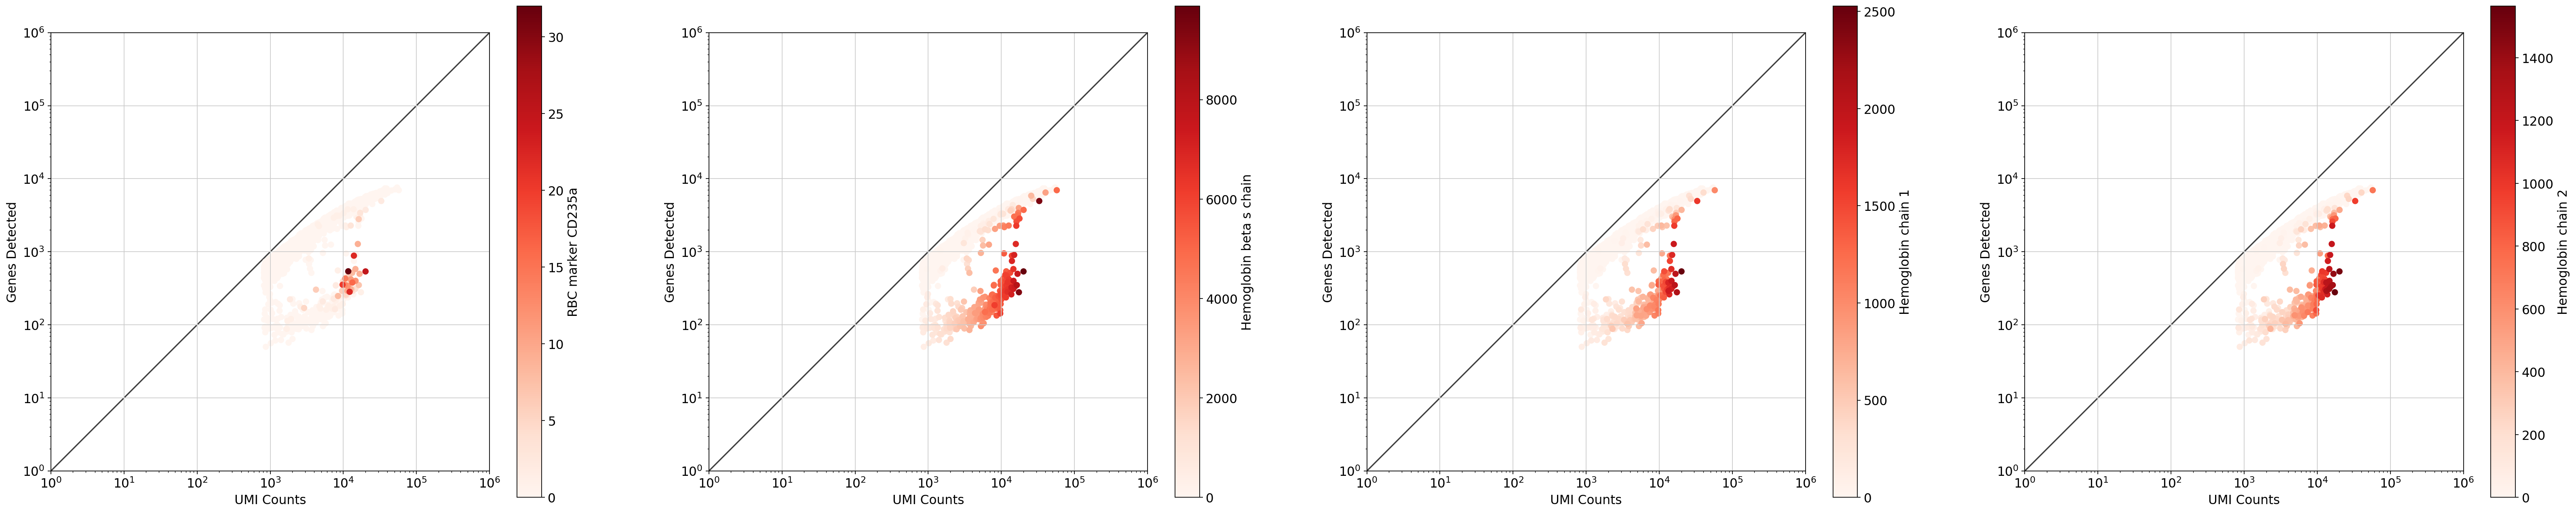

In [38]:
fig, axs = plt.subplots(figsize=(50,10), ncols=4)
i=0

for ax, gene in zip(axs, RBC_genes):
    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains(gene)].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    fig.colorbar(scatter, ax=ax, label=titles_RBC[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    # ax.set_title("{}".format(adata.obs.batch.values[0]))
    yex(ax)
    
    i+=1

fig.show()

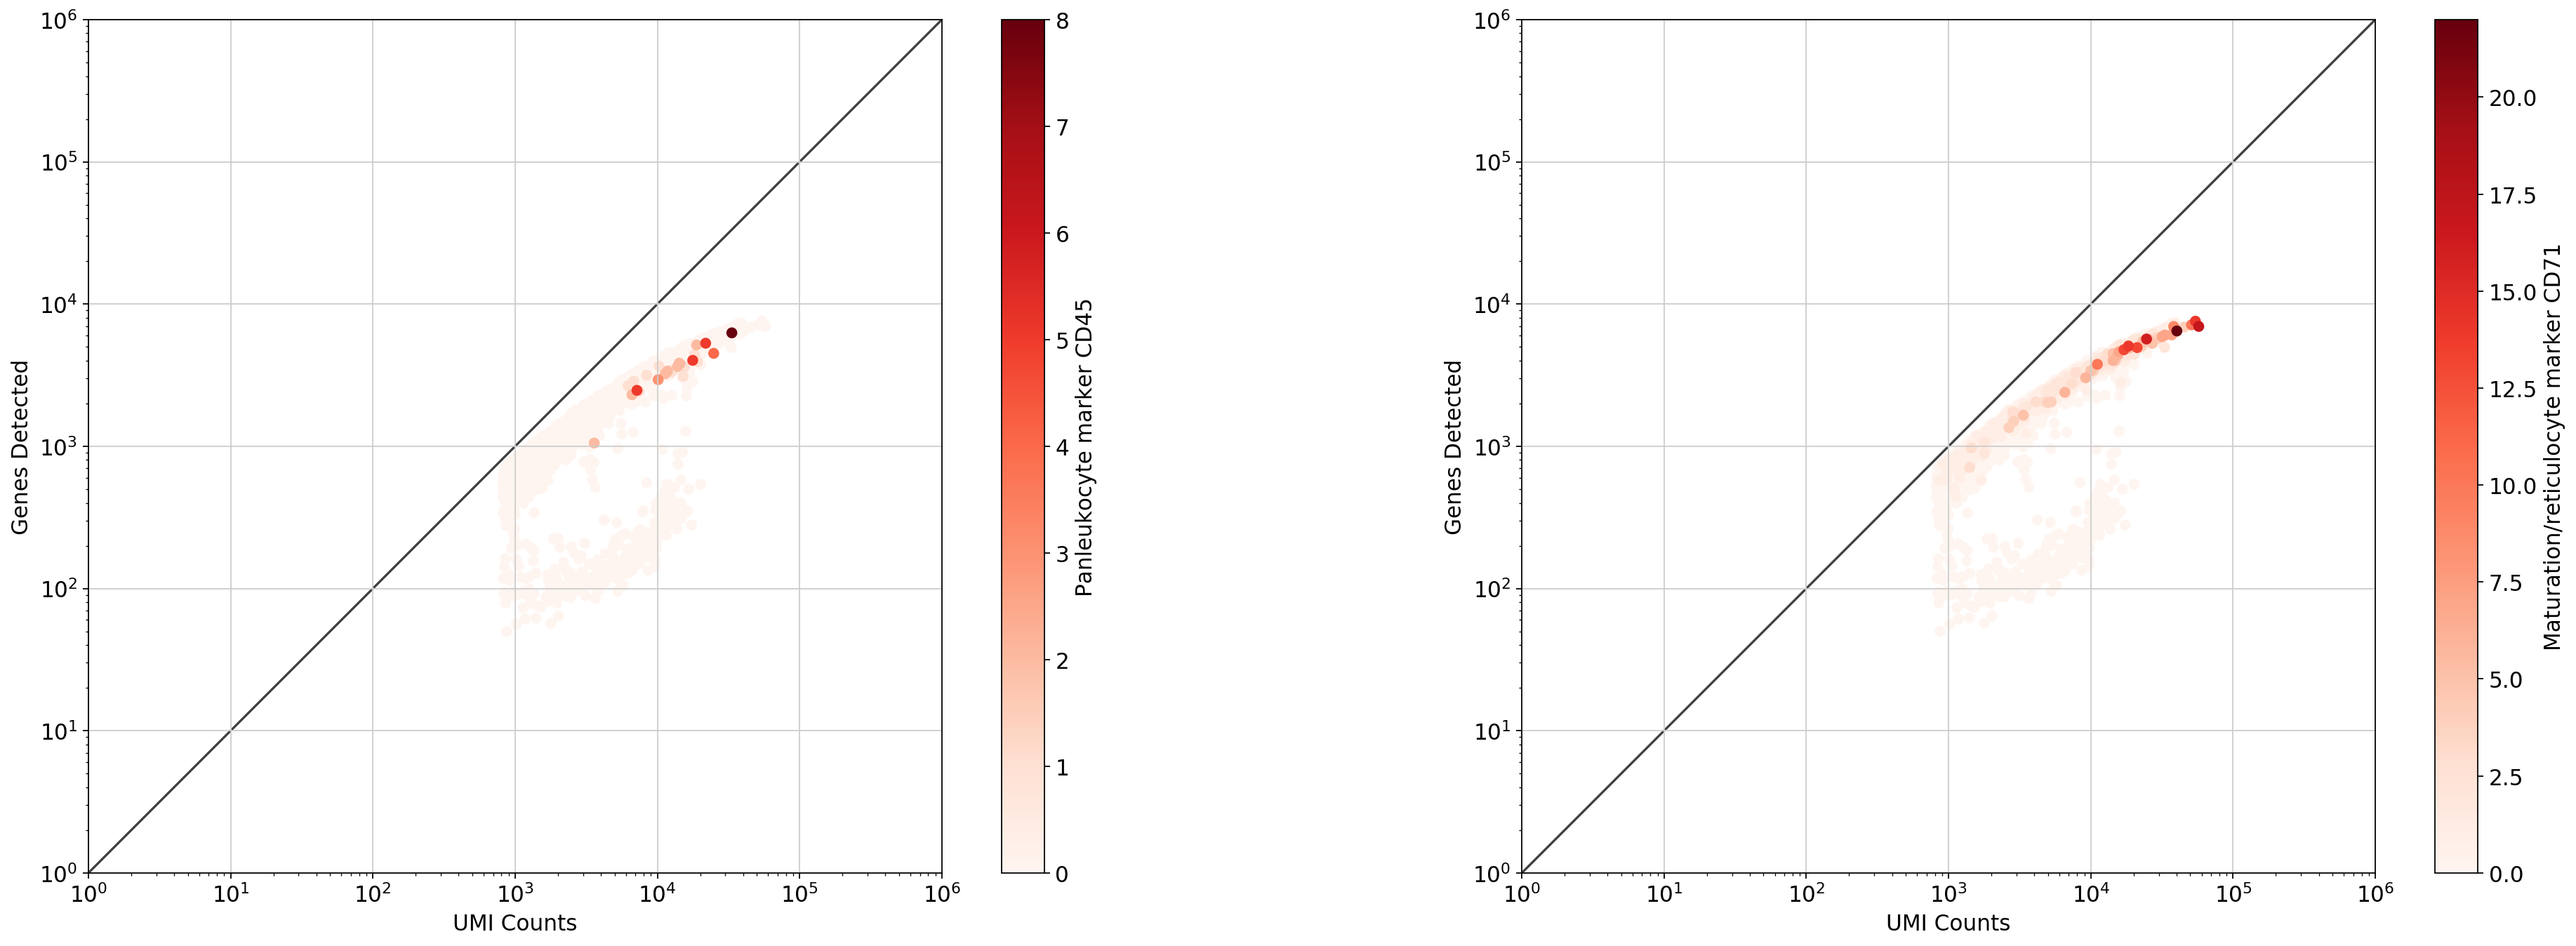

In [39]:
fig, axs = plt.subplots(figsize=(30,10), ncols=2)
i=0

for ax, gene in zip(axs, reti_genes):
    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains(gene)].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    fig.colorbar(scatter, ax=ax, label=titles_reti[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    # ax.set_title("{}".format(adata.obs.batch.values[0]))
    yex(ax)
    
    i+=1

fig.show()